# Import Library ( PyTorch )

In [1]:
# Import Framework
import torch
import torch.nn as nn
import torch.nn.functional as F

# Import Library
import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pickle
import random

# Fix Random 
torch.manual_seed(0)

## Setting Hyper-Parameters

In [2]:
# VGG configure
cfg = {
    'A' : [64,     'M', 128,      'M', 256, 256,           'M', 512, 512,           'M', 512, 512,           'M'],
    'B' : [64, 64, 'M', 128, 128, 'M', 256, 256,           'M', 512, 512,           'M', 512, 512,           'M'],
    'D' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256,      'M', 512, 512, 512,      'M', 512, 512, 512,      'M'],
    'E' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

# Model Hyper-Parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.0001
num_classes = 10
softmax = True
# Adam betas
#betas = (0.9, 0.999)

# L2 Regularization
weight_decay = 0.001

# DataLoader Hyper-Parameters
batch_size = 128
shuffle = True
drop_last = True
num_workers = 4

# Train Hyper-Parameters
EPOCH = 30
criterion = nn.BCELoss()



## Define Model ( VGG )


In [3]:
class VGG(nn.Module):

    def __init__(self, features, num_classes=100, softmax = True):
        super().__init__()
        self.features = features
        
        # if your dataset is STL10, fc *= 9
        fc = 512
        
        self.classifier = nn.Sequential(
            nn.Linear(fc, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )
        self.softmax = softmax

    def forward(self, x):
        output = self.features(x)
        output = output.view(output.size()[0], -1)
        output = self.classifier(output)
        
        if self.softmax:
            output = F.softmax(output, dim = 1)
        return output

def make_layers(cfg, batch_norm=False):
    layers = []

    input_channel = 3
    for l in cfg:
        if l == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            continue

        layers += [nn.Conv2d(input_channel, l, kernel_size=3, padding=1)]

        if batch_norm:
            layers += [nn.BatchNorm2d(l)]

        layers += [nn.ReLU(inplace=True)]
        input_channel = l

    return nn.Sequential(*layers)

def vgg11_bn(num_classes = 10, softmax = True):
    return VGG(make_layers(cfg['A'], batch_norm=True), num_classes = num_classes, softmax = softmax)

def vgg13_bn(num_classes = 10, softmax = True):
    return VGG(make_layers(cfg['B'], batch_norm=True), num_classes = num_classes, softmax = softmax)

def vgg16_bn(num_classes = 10, softmax = True):
    return VGG(make_layers(cfg['D'], batch_norm=True), num_classes = num_classes, softmax = softmax)

def vgg19_bn(num_classes = 10, softmax = True):
    return VGG(make_layers(cfg['E'], batch_norm=True), num_classes = num_classes, softmax = softmax)


## Define Model ( ResNet )


In [4]:
# Define Residual Block
class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))
    
# Define ResNet Model
class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100, softmax = True):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.softmax = softmax

    def _make_layer(self, block, out_channels, num_blocks, stride):

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)
        
        if self.softmax:
            output = F.softmax(output, dim = 1)

        return output

def resnet18(num_classes=10, softmax = True):
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes = num_classes, softmax = softmax)

def resnet34(num_classes=10, softmax = True):
    """ return a ResNet 34 object
    """
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes = num_classes, softmax = softmax)


### SoftMax Function
\begin{align}
\ f(\vec{x}) = {x_i \over \sum_{i}{x_i}}
\end{align}

 
## Define Train Detail
 

In [5]:
# Define Model

# VGG19
Model = vgg19_bn(num_classes = num_classes, softmax = softmax)


# ResNet34

#Model = resnet34(num_classes = num_classes, softmax = softmax).to(device = device)

# Allocate CUDA
Model = Model.to(device = device)


# Define Optimizer : Adam
optimizer = torch.optim.Adam(Model.parameters(), lr = learning_rate, weight_decay = weight_decay)
schduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

## Define DataSet / DataLoader

In [6]:
pwd

'/home/jryoungw/Downloads/JH/Hands-On/Classification'

In [7]:
# import torchvision

# Write Your Path
# pwd
# PATH = ''
# torchvision.datasets.STL10(PATH, download = True)
# torchvision.datasets.CIFAR10(PATH, download = True)

In [8]:
# STL10 Dataset
class STL10_Dataset(torch.utils.data.Dataset):
    def __init__(self, path = 'stl10_binary/', use = 'train', one_hot = True):
        super(STL10_Dataset, self).__init__()
        self.path = path
        self.image = use+'_X.bin'
        self.label = use+'_y.bin'
        self.one_hot = one_hot
        
        self._loadfile()
        
    # Load Bin file
    def _loadfile(self):
        with open(self.path + self.image) as f:
            self.image = np.fromfile(f, dtype=np.uint8)
            # Image Size : ( 96 x 96 )
            self.image = np.reshape(self.image, (-1, 3, 96, 96))
            self.image = np.transpose(self.image, (0, 1, 3, 2))/255.
            
        with open(self.path + self.label) as f:
            self.label = np.fromfile(f, dtype=np.uint8) - 1  # 0-based
    
    def __len__(self):
        return self.image.shape[0]
    
    def __getitem__(self, idx):
        
        # One-hot Encoder ( label = 1 -> label = [0,1,0,0,0,0,0,0,0,0] )
        if self.one_hot:
            label = np.zeros(10)
            label[self.label[idx]] = 1
        else:
            label = self.label[idx]
            
        image = self.image[idx]
        
        return image, label

In [53]:
# CIFAR10 Dataset
class CIFAR10_Dataset(torch.utils.data.Dataset):
    def __init__(self, path = 'cifar-10-batches-py/', use = 'train', one_hot = True):
        super(CIFAR10_Dataset, self).__init__()
        self.path = path
        if use == 'train':
            self.X = [f'data_batch_{i}.bin' for i in range(1,6)]
        if use == 'test':
            self.X = [f'test_batch.bin']
        self.one_hot = one_hot
        
        self._loadfile()
        
    # Load Bin file
    def _loadfile(self):
        self.label = []
        self.image = []
        for x in self.X:
            with open(self.path + x, 'rb') as f:
                X = pickle.load(f, encoding = 'bytes')

            self.label.append(np.array(X[b'labels']))
            self.image.append(X[b'data'].reshape(-1, 3, 32, 32)/255.)
        
        self.label = np.concatenate(self.label)
        self.image = np.concatenate(self.image)
        del(self.X)
            

    def __len__(self):
        return self.image.shape[0]
    
    def __getitem__(self, idx):
        
        # One-hot Encoder ( label = 1 -> label = [0,1,0,0,0,0,0,0,0,0] )
        if self.one_hot:
            label = np.zeros(10)
            label[self.label[idx]] = 1
        else:
            label = self.label[idx]
            
        image = self.image[idx]
        
        return torch.Tensor(image), torch.Tensor(label).view(1, -1)

In [54]:
# Define Dataset
train_dataset = CIFAR10_Dataset(use = 'train')
test_dataset = CIFAR10_Dataset(use = 'test')

# Define Dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = shuffle, drop_last = drop_last, num_workers = num_workers)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 100, shuffle = shuffle, drop_last = False, num_workers = num_workers)

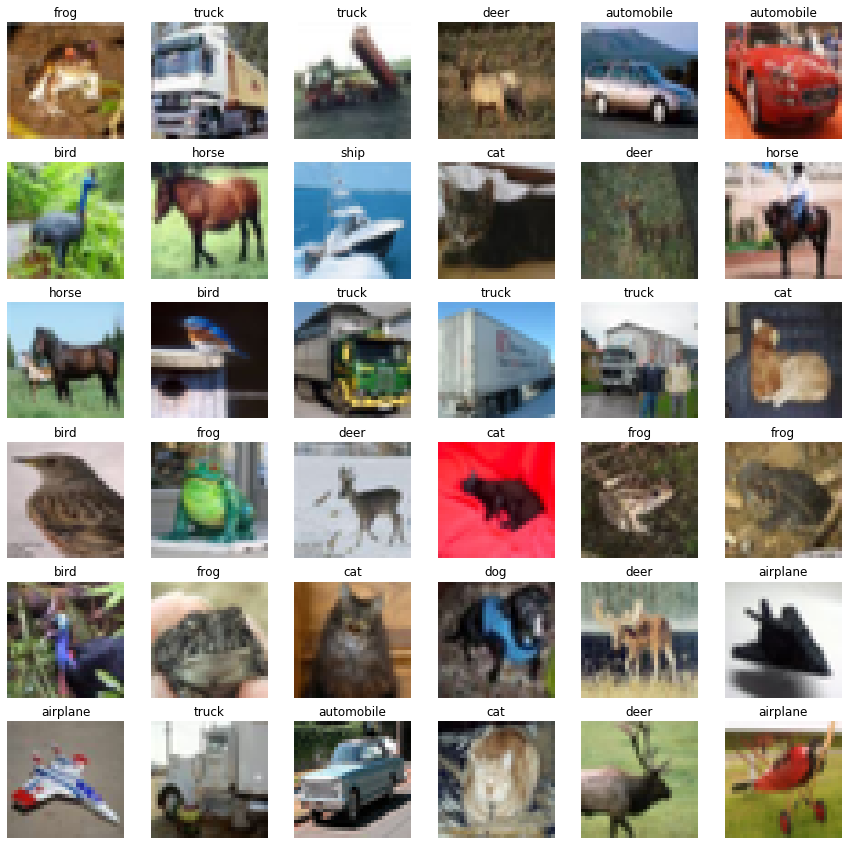

In [82]:
axis = 6

sample = next(iter(torch.utils.data.DataLoader(train_dataset, batch_size = axis*axis)))
sample_image = sample[0]
sample_label = sample[1]

label = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig = plt.figure(figsize = (15,15))

sample_image = sample[0]
sampel_label = sample[1]


for row in range(axis):
    for col in range(axis):
        ax = fig.add_subplot(rows, cols, (row*axis + col)+1)
        ax.imshow(sample_image[row*axis + col].numpy().transpose((1, 2, 0)))
        ax.axis('off')
        ax.set_title(label[torch.argmax(sample_label[row*axis + col])])
        
plt.show()

## Train

In [12]:
Train_Loss = []
Test_Loss  = []

Train_ACC  = []
Test_ACC   = []

for epoch in range(EPOCH):
    # Make dataloader loop
    pbar = tqdm.tqdm(enumerate(train_dataloader), total = len(train_dataloader))
    
    # total length train_dataloader
    train_len = len(train_dataloader)
    
    # Setting Training Mode ( to set dropout / batch normalization )
    Model.train()
    
    total = 0
    correct = 0
    train_loss = []
    test_loss = []
    
    for i, (X, y) in pbar:
        # Allocate CUDA
        X, y = X.to(device = device).float(), y.to(device = device).float()
                
        # prediction
        pred = Model(X)
        
        # calculate loss
        loss = criterion(pred.float(), y)
        
        # optimizer gradient zero setting
        optimizer.zero_grad()
        
        # backward loss
        loss.backward()
        
        # optimizer step train
        optimizer.step()
        
        total += X.shape[0]
        correct += torch.sum(torch.argmax(pred,1) == torch.argmax(y,1)).item()

        
        msg = f'[Train] [{epoch+1:02}/{EPOCH}] [{i:02}/{train_len}] [ Loss : {loss.item():.3f} ] [ Accuracy : {(correct / total) * 100 : .3f}% ]'
        
        pbar.set_description_str(msg)
        train_loss.append(loss.item())
    Train_ACC.append((correct/total)*100)
    Train_Loss.append(sum(train_loss)/len(train_loss))
        
    test_pbar = tqdm.tqdm(enumerate(test_dataloader), total = len(test_dataloader))
    
    Model.eval()
    
    total = 0
    correct = 0
    
    # No calculate Gradient. If you inference, use this method
    with torch.no_grad():
        test_len = len(test_pbar)
        for i, (X, y) in test_pbar:
            X, y = X.to(device = device).float(), y.to(device = device).float()
            pred = Model(X)
            loss = criterion(pred, y)
            total += X.shape[0]
            correct += torch.sum(torch.argmax(pred,1) == torch.argmax(y,1)).item()

            msg = f'[Test]  [{epoch+1:02}/{EPOCH}] [{i:02}/{test_len}] [ Loss : {loss.item():.3f} ] [ Accuracy : {(correct / total) * 100 : .3f}% ]'
            test_pbar.set_description_str(msg)
            test_loss.append(loss.item())
    Test_ACC.append((correct/total)*100)
    Test_Loss.append(sum(test_loss)/len(test_loss))
    schduler.step()
    print()
    print(f' [ EPOCH : {epoch+1:02} ] [ Train loss : {Train_Loss[-1]:.3f} ][ Train acc : {Train_ACC[-1]:.3f}% ] [ Test loss : {Test_Loss[-1]:.3f} ][ Test acc : {Test_ACC[-1]:.3f}% ]')
    print()

[Train] [01/30] [389/390] [ Loss : 0.182 ] [ Accuracy :  48.520% ]: 100%|██████████| 390/390 [00:27<00:00, 14.24it/s]
[Test]  [01/30] [99/100] [ Loss : 0.195 ] [ Accuracy :  60.630% ]: 100%|██████████| 100/100 [00:01<00:00, 57.07it/s]


 [ EPOCH : 01 ] [ Train loss : 0.216 ][ Train acc : 48.520% ] [ Test loss : 0.181 ][ Test acc : 60.630% ]




[Train] [02/30] [389/390] [ Loss : 0.144 ] [ Accuracy :  67.342% ]: 100%|██████████| 390/390 [00:27<00:00, 14.36it/s]
[Test]  [02/30] [99/100] [ Loss : 0.159 ] [ Accuracy :  64.910% ]: 100%|██████████| 100/100 [00:01<00:00, 60.58it/s]


 [ EPOCH : 02 ] [ Train loss : 0.152 ][ Train acc : 67.342% ] [ Test loss : 0.166 ][ Test acc : 64.910% ]




[Train] [03/30] [389/390] [ Loss : 0.104 ] [ Accuracy :  75.126% ]: 100%|██████████| 390/390 [00:26<00:00, 14.76it/s]
[Test]  [03/30] [99/100] [ Loss : 0.149 ] [ Accuracy :  72.050% ]: 100%|██████████| 100/100 [00:01<00:00, 60.97it/s]


 [ EPOCH : 03 ] [ Train loss : 0.121 ][ Train acc : 75.126% ] [ Test loss : 0.135 ][ Test acc : 72.050% ]




[Train] [04/30] [389/390] [ Loss : 0.118 ] [ Accuracy :  80.182% ]: 100%|██████████| 390/390 [00:26<00:00, 14.78it/s]
[Test]  [04/30] [99/100] [ Loss : 0.109 ] [ Accuracy :  71.370% ]: 100%|██████████| 100/100 [00:01<00:00, 61.05it/s]


 [ EPOCH : 04 ] [ Train loss : 0.100 ][ Train acc : 80.182% ] [ Test loss : 0.145 ][ Test acc : 71.370% ]




[Train] [05/30] [389/390] [ Loss : 0.074 ] [ Accuracy :  84.317% ]: 100%|██████████| 390/390 [00:26<00:00, 14.75it/s]
[Test]  [05/30] [99/100] [ Loss : 0.142 ] [ Accuracy :  76.540% ]: 100%|██████████| 100/100 [00:01<00:00, 61.04it/s]


 [ EPOCH : 05 ] [ Train loss : 0.082 ][ Train acc : 84.317% ] [ Test loss : 0.121 ][ Test acc : 76.540% ]




[Train] [06/30] [389/390] [ Loss : 0.072 ] [ Accuracy :  87.562% ]: 100%|██████████| 390/390 [00:26<00:00, 14.75it/s]
[Test]  [06/30] [99/100] [ Loss : 0.158 ] [ Accuracy :  76.310% ]: 100%|██████████| 100/100 [00:01<00:00, 61.04it/s]


 [ EPOCH : 06 ] [ Train loss : 0.067 ][ Train acc : 87.562% ] [ Test loss : 0.126 ][ Test acc : 76.310% ]




[Train] [07/30] [389/390] [ Loss : 0.057 ] [ Accuracy :  90.210% ]: 100%|██████████| 390/390 [00:26<00:00, 14.73it/s]
[Test]  [07/30] [99/100] [ Loss : 0.124 ] [ Accuracy :  76.300% ]: 100%|██████████| 100/100 [00:01<00:00, 61.03it/s]


 [ EPOCH : 07 ] [ Train loss : 0.053 ][ Train acc : 90.210% ] [ Test loss : 0.137 ][ Test acc : 76.300% ]




[Train] [08/30] [389/390] [ Loss : 0.059 ] [ Accuracy :  92.424% ]: 100%|██████████| 390/390 [00:26<00:00, 14.73it/s]
[Test]  [08/30] [99/100] [ Loss : 0.114 ] [ Accuracy :  78.440% ]: 100%|██████████| 100/100 [00:01<00:00, 60.94it/s]


 [ EPOCH : 08 ] [ Train loss : 0.043 ][ Train acc : 92.424% ] [ Test loss : 0.121 ][ Test acc : 78.440% ]




[Train] [09/30] [389/390] [ Loss : 0.035 ] [ Accuracy :  94.389% ]: 100%|██████████| 390/390 [00:26<00:00, 14.72it/s]
[Test]  [09/30] [99/100] [ Loss : 0.232 ] [ Accuracy :  77.140% ]: 100%|██████████| 100/100 [00:01<00:00, 61.14it/s]


 [ EPOCH : 09 ] [ Train loss : 0.032 ][ Train acc : 94.389% ] [ Test loss : 0.139 ][ Test acc : 77.140% ]




[Train] [10/30] [389/390] [ Loss : 0.026 ] [ Accuracy :  95.707% ]: 100%|██████████| 390/390 [00:26<00:00, 14.70it/s]
[Test]  [10/30] [99/100] [ Loss : 0.129 ] [ Accuracy :  80.350% ]: 100%|██████████| 100/100 [00:01<00:00, 61.04it/s]


 [ EPOCH : 10 ] [ Train loss : 0.026 ][ Train acc : 95.707% ] [ Test loss : 0.118 ][ Test acc : 80.350% ]




[Train] [11/30] [389/390] [ Loss : 0.021 ] [ Accuracy :  96.851% ]: 100%|██████████| 390/390 [00:26<00:00, 14.60it/s]
[Test]  [11/30] [99/100] [ Loss : 0.120 ] [ Accuracy :  78.820% ]: 100%|██████████| 100/100 [00:01<00:00, 60.63it/s]



 [ EPOCH : 11 ] [ Train loss : 0.020 ][ Train acc : 96.851% ] [ Test loss : 0.138 ][ Test acc : 78.820% ]



[Train] [12/30] [389/390] [ Loss : 0.017 ] [ Accuracy :  97.302% ]: 100%|██████████| 390/390 [00:26<00:00, 14.47it/s]
[Test]  [12/30] [99/100] [ Loss : 0.222 ] [ Accuracy :  77.690% ]: 100%|██████████| 100/100 [00:01<00:00, 59.77it/s]


 [ EPOCH : 12 ] [ Train loss : 0.017 ][ Train acc : 97.302% ] [ Test loss : 0.153 ][ Test acc : 77.690% ]




[Train] [13/30] [389/390] [ Loss : 0.011 ] [ Accuracy :  98.019% ]: 100%|██████████| 390/390 [00:26<00:00, 14.47it/s]
[Test]  [13/30] [99/100] [ Loss : 0.167 ] [ Accuracy :  79.040% ]: 100%|██████████| 100/100 [00:01<00:00, 60.38it/s]


 [ EPOCH : 13 ] [ Train loss : 0.013 ][ Train acc : 98.019% ] [ Test loss : 0.142 ][ Test acc : 79.040% ]




[Train] [14/30] [389/390] [ Loss : 0.012 ] [ Accuracy :  98.377% ]: 100%|██████████| 390/390 [00:27<00:00, 14.31it/s]
[Test]  [14/30] [99/100] [ Loss : 0.108 ] [ Accuracy :  81.240% ]: 100%|██████████| 100/100 [00:01<00:00, 53.84it/s]


 [ EPOCH : 14 ] [ Train loss : 0.011 ][ Train acc : 98.377% ] [ Test loss : 0.134 ][ Test acc : 81.240% ]




[Train] [15/30] [389/390] [ Loss : 0.020 ] [ Accuracy :  98.896% ]: 100%|██████████| 390/390 [00:28<00:00, 13.47it/s]
[Test]  [15/30] [99/100] [ Loss : 0.138 ] [ Accuracy :  81.650% ]: 100%|██████████| 100/100 [00:01<00:00, 56.31it/s]


 [ EPOCH : 15 ] [ Train loss : 0.008 ][ Train acc : 98.896% ] [ Test loss : 0.140 ][ Test acc : 81.650% ]




[Train] [16/30] [389/390] [ Loss : 0.005 ] [ Accuracy :  99.052% ]: 100%|██████████| 390/390 [00:28<00:00, 13.52it/s]
[Test]  [16/30] [99/100] [ Loss : 0.155 ] [ Accuracy :  81.500% ]: 100%|██████████| 100/100 [00:01<00:00, 56.66it/s]


 [ EPOCH : 16 ] [ Train loss : 0.007 ][ Train acc : 99.052% ] [ Test loss : 0.143 ][ Test acc : 81.500% ]




[Train] [17/30] [389/390] [ Loss : 0.014 ] [ Accuracy :  99.185% ]: 100%|██████████| 390/390 [00:28<00:00, 13.63it/s]
[Test]  [17/30] [99/100] [ Loss : 0.128 ] [ Accuracy :  80.280% ]: 100%|██████████| 100/100 [00:01<00:00, 56.68it/s]


 [ EPOCH : 17 ] [ Train loss : 0.006 ][ Train acc : 99.185% ] [ Test loss : 0.154 ][ Test acc : 80.280% ]




[Train] [18/30] [389/390] [ Loss : 0.003 ] [ Accuracy :  99.221% ]: 100%|██████████| 390/390 [00:27<00:00, 14.25it/s]
[Test]  [18/30] [99/100] [ Loss : 0.137 ] [ Accuracy :  81.730% ]: 100%|██████████| 100/100 [00:01<00:00, 59.80it/s]


 [ EPOCH : 18 ] [ Train loss : 0.006 ][ Train acc : 99.221% ] [ Test loss : 0.138 ][ Test acc : 81.730% ]




[Train] [19/30] [389/390] [ Loss : 0.002 ] [ Accuracy :  99.413% ]: 100%|██████████| 390/390 [00:27<00:00, 14.42it/s]
[Test]  [19/30] [99/100] [ Loss : 0.156 ] [ Accuracy :  81.630% ]: 100%|██████████| 100/100 [00:01<00:00, 59.87it/s]


 [ EPOCH : 19 ] [ Train loss : 0.005 ][ Train acc : 99.413% ] [ Test loss : 0.144 ][ Test acc : 81.630% ]




[Train] [20/30] [389/390] [ Loss : 0.003 ] [ Accuracy :  99.597% ]: 100%|██████████| 390/390 [00:26<00:00, 14.46it/s]
[Test]  [20/30] [99/100] [ Loss : 0.144 ] [ Accuracy :  81.490% ]: 100%|██████████| 100/100 [00:01<00:00, 60.31it/s]


 [ EPOCH : 20 ] [ Train loss : 0.004 ][ Train acc : 99.597% ] [ Test loss : 0.147 ][ Test acc : 81.490% ]




[Train] [21/30] [389/390] [ Loss : 0.003 ] [ Accuracy :  99.539% ]: 100%|██████████| 390/390 [00:27<00:00, 14.41it/s]
[Test]  [21/30] [99/100] [ Loss : 0.138 ] [ Accuracy :  81.710% ]: 100%|██████████| 100/100 [00:01<00:00, 56.69it/s]


 [ EPOCH : 21 ] [ Train loss : 0.004 ][ Train acc : 99.539% ] [ Test loss : 0.152 ][ Test acc : 81.710% ]




[Train] [22/30] [389/390] [ Loss : 0.005 ] [ Accuracy :  99.655% ]: 100%|██████████| 390/390 [00:27<00:00, 14.39it/s]
[Test]  [22/30] [99/100] [ Loss : 0.104 ] [ Accuracy :  82.190% ]: 100%|██████████| 100/100 [00:01<00:00, 59.89it/s]


 [ EPOCH : 22 ] [ Train loss : 0.003 ][ Train acc : 99.655% ] [ Test loss : 0.154 ][ Test acc : 82.190% ]




[Train] [23/30] [389/390] [ Loss : 0.001 ] [ Accuracy :  99.659% ]: 100%|██████████| 390/390 [00:27<00:00, 14.38it/s]
[Test]  [23/30] [99/100] [ Loss : 0.199 ] [ Accuracy :  81.600% ]: 100%|██████████| 100/100 [00:01<00:00, 59.41it/s]


 [ EPOCH : 23 ] [ Train loss : 0.003 ][ Train acc : 99.659% ] [ Test loss : 0.150 ][ Test acc : 81.600% ]




[Train] [24/30] [389/390] [ Loss : 0.002 ] [ Accuracy :  99.756% ]: 100%|██████████| 390/390 [00:27<00:00, 14.40it/s]
[Test]  [24/30] [99/100] [ Loss : 0.173 ] [ Accuracy :  82.490% ]: 100%|██████████| 100/100 [00:01<00:00, 59.25it/s]


 [ EPOCH : 24 ] [ Train loss : 0.002 ][ Train acc : 99.756% ] [ Test loss : 0.156 ][ Test acc : 82.490% ]




[Train] [25/30] [389/390] [ Loss : 0.001 ] [ Accuracy :  99.784% ]: 100%|██████████| 390/390 [00:27<00:00, 14.39it/s]
[Test]  [25/30] [99/100] [ Loss : 0.135 ] [ Accuracy :  82.220% ]: 100%|██████████| 100/100 [00:01<00:00, 60.10it/s]


 [ EPOCH : 25 ] [ Train loss : 0.002 ][ Train acc : 99.784% ] [ Test loss : 0.152 ][ Test acc : 82.220% ]




[Train] [26/30] [389/390] [ Loss : 0.001 ] [ Accuracy :  99.830% ]: 100%|██████████| 390/390 [00:27<00:00, 14.44it/s]
[Test]  [26/30] [99/100] [ Loss : 0.113 ] [ Accuracy :  82.430% ]: 100%|██████████| 100/100 [00:01<00:00, 59.96it/s]


 [ EPOCH : 26 ] [ Train loss : 0.002 ][ Train acc : 99.830% ] [ Test loss : 0.152 ][ Test acc : 82.430% ]




[Train] [27/30] [389/390] [ Loss : 0.001 ] [ Accuracy :  99.846% ]: 100%|██████████| 390/390 [00:26<00:00, 14.45it/s]
[Test]  [27/30] [99/100] [ Loss : 0.143 ] [ Accuracy :  82.310% ]: 100%|██████████| 100/100 [00:01<00:00, 59.96it/s]


 [ EPOCH : 27 ] [ Train loss : 0.002 ][ Train acc : 99.846% ] [ Test loss : 0.156 ][ Test acc : 82.310% ]




[Train] [28/30] [389/390] [ Loss : 0.001 ] [ Accuracy :  99.890% ]: 100%|██████████| 390/390 [00:27<00:00, 14.36it/s]
[Test]  [28/30] [99/100] [ Loss : 0.170 ] [ Accuracy :  82.520% ]: 100%|██████████| 100/100 [00:01<00:00, 58.00it/s]


 [ EPOCH : 28 ] [ Train loss : 0.002 ][ Train acc : 99.890% ] [ Test loss : 0.151 ][ Test acc : 82.520% ]




[Train] [29/30] [389/390] [ Loss : 0.001 ] [ Accuracy :  99.890% ]: 100%|██████████| 390/390 [00:27<00:00, 14.24it/s]
[Test]  [29/30] [99/100] [ Loss : 0.112 ] [ Accuracy :  82.000% ]: 100%|██████████| 100/100 [00:01<00:00, 56.21it/s]


 [ EPOCH : 29 ] [ Train loss : 0.001 ][ Train acc : 99.890% ] [ Test loss : 0.155 ][ Test acc : 82.000% ]




[Train] [30/30] [389/390] [ Loss : 0.001 ] [ Accuracy :  99.854% ]: 100%|██████████| 390/390 [00:27<00:00, 14.41it/s]
[Test]  [30/30] [99/100] [ Loss : 0.115 ] [ Accuracy :  82.440% ]: 100%|██████████| 100/100 [00:01<00:00, 60.35it/s]


 [ EPOCH : 30 ] [ Train loss : 0.002 ][ Train acc : 99.854% ] [ Test loss : 0.154 ][ Test acc : 82.440% ]



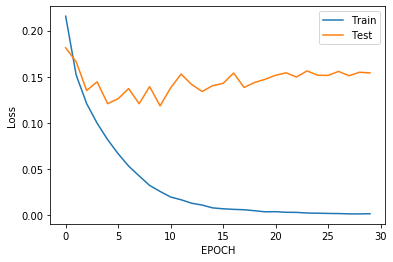

In [13]:
plt.plot(Train_Loss, label = 'Train')
plt.plot(Test_Loss, label = 'Test')

plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

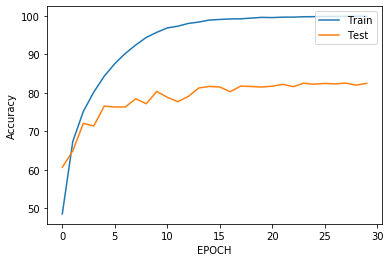

In [14]:
plt.plot(Train_ACC, label = 'Train')
plt.plot(Test_ACC, label = 'Test')

plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')


plt.show()